In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import xarray as xr
from cycle_detection import detect_respiration_cycles
from respiration_features import get_all_respiration_features
from params import patient, respi_chan, srate , rsp_detect_sign
import ghibtools as gh
%matplotlib widget

## LOAD 

In [3]:
patient

'P17'

In [4]:
save = False

In [5]:
da = xr.load_dataarray(f'../dataarray/da_N2N3_{patient}.nc').sel(chan = respi_chan)

## TOOLS

In [6]:
def rsp_cycle_detection(resp_sig, srate=srate):

    cycles = detect_respiration_cycles(resp_sig, sampling_rate=srate, t_start = 0., output = 'index',

                                    # preprocessing
                                    inspiration_sign = '+',
                                    high_pass_filter = None,
                                    constrain_frequency = None,
                                    median_windows_filter = None,

                                    # baseline
                                    baseline_with_average = True,
                                    manual_baseline = 0.,

                                    # clean
                                    eliminate_time_shortest_ratio = 2,
                                    eliminate_amplitude_shortest_ratio = 10,
                                    eliminate_mode = 'OR', # 'AND'

                                    )

    return cycles

## CYCLE DETECTION

In [7]:
rsp = da.values
t = da.coords['time'].values
cycles = rsp_cycle_detection(rsp)
inspis = cycles[:,0]
expis = cycles[:,1]

## RESP FEATURES FROM CYCLES & RESP

In [8]:
duration_min=1.5
duration_max = 20
inspi_min=0.5
inspi_max=10

In [9]:
resp_features = get_all_respiration_features(resp_sig=rsp, sampling_rate=srate, cycles=cycles, t_start = 0.)
resp_features.insert(0, 'participant',patient)
initial_n_cycles = resp_features.shape[0]
clean_cycles = []
for i , cycle in resp_features.iterrows():
    if cycle['cycle_duration'] > duration_min and cycle['cycle_duration'] < duration_max and cycle['insp_duration'] > inspi_min and cycle['insp_duration'] < inspi_max and cycle['exp_duration'] > inspi_min and cycle['exp_duration'] < inspi_max:
        clean_cycles.append(cycle)

df_return = pd.concat(clean_cycles, axis = 1).T

print(f'{initial_n_cycles - df_return.shape[0]} cycles removed')
if save:
    print('SAVING')
    df_return.to_excel(f'../df_analyse/resp_features_{patient}.xlsx')


/mnt/autofs/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/scripts/respiration_features.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df[k] = pd.Series(index = index)
/mnt/autofs/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/scripts/respiration_features.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df[k] = pd.Series(index = index)
/mnt/autofs/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/scripts/respiration_features.py:52: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df[k] = pd.Series(index = index)
/mnt/autofs/cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/scripts/respiration_features.py:52: FutureWarning: The default dtype for empty Series will b

2 cycles removed


In [10]:
df_return[['cycle_duration','insp_duration','exp_duration','cycle_freq']].mean()

cycle_duration    3.537278
insp_duration     1.149950
exp_duration      2.387328
cycle_freq        0.284878
dtype: float64

In [11]:
df_return

,participant,cycle_num,inspi_index,expi_index,inspi_time,expi_time,cycle_duration,insp_duration,exp_duration,cycle_freq,insp_volume,exp_volume,total_amplitude,insp_amplitude,exp_amplitude
0,P17,0,95,365,0.371094,1.425781,2.839844,1.054688,1.785156,0.352132,8.317999,-21.227133,41.312007,12.556966,28.755041
1,P17,1,822,1143,3.210938,4.464844,3.402344,1.253906,2.148438,0.293915,8.692388,-20.090691,30.558887,14.757697,15.80119
2,P17,2,1693,1993,6.613281,7.785156,3.140625,1.171875,1.96875,0.318408,9.253947,-21.892333,39.03817,11.875055,27.163115
3,P17,3,2497,2821,9.753906,11.019531,3.023438,1.265625,1.757812,0.330749,11.210507,-23.139888,42.445276,15.231385,27.213891
4,P17,4,3271,3554,12.777344,13.882812,2.511719,1.105469,1.40625,0.398134,8.552079,-19.266545,40.167514,12.31723,27.850284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5142,P17,5142,4710331,4710629,18399.730469,18400.894531,3.304688,1.164062,2.140625,0.3026,8.650279,-19.084083,32.660651,11.927346,20.733305
5143,P17,5143,4711177,4711471,18403.035156,18404.183594,4.652344,1.148438,3.503906,0.214945,8.424914,-24.4549,32.851057,11.9037,20.947357
5144,P17,5144,4712368,4712718,18407.6875,18409.054688,3.609375,1.367188,2.242188,0.277056,3.885094,-16.213358,19.843348,6.631736,13.211612
5145,P17,5145,4713292,4713598,18411.296875,18412.492188,3.570312,1.195312,2.375,0.280088,7.744302,-19.81557,30.597213,10.141515,20.455698


In [12]:
clean_inspis = df_return['inspi_index'].to_numpy(dtype = int)
clean_expis = df_return['expi_index'].to_numpy(dtype = int)

In [13]:
clean_inspis

array([     95,     822,    1693, ..., 4712368, 4713292, 4714206])

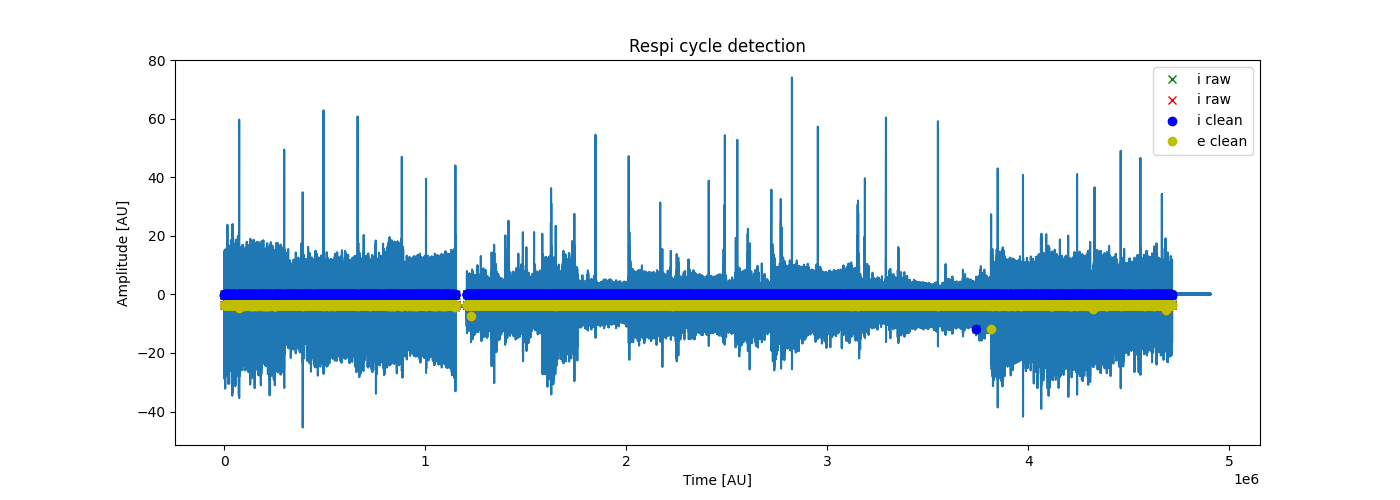

In [14]:
fig, ax = plt.subplots(figsize = (14,5))
ax.plot(rsp)
ax.plot(inspis, rsp[inspis], 'x', color = 'g', label = 'i raw')
ax.plot(expis, rsp[expis], 'x', color = 'r', label = 'i raw')
ax.plot(clean_inspis, rsp[clean_inspis], 'o', color = 'b', label = 'i clean')
ax.plot(clean_expis, rsp[clean_expis], 'o', color = 'y', label = 'e clean')
ax.set_title(f'Respi cycle detection')
ax.set_ylabel('Amplitude [AU]')
ax.set_xlabel('Time [AU]')
ax.legend()
plt.show()